In [1]:
import os
os.chdir("C:\\Users\\Adhvaidh\\Downloads")

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
ds=pd.read_csv("US Dollar Index Futures Historical Data (2).csv")

In [4]:
ds.tail()

,Date,Price,Open,High,Low,Vol.,Change %
1545,"May 25, 2020",99.888,99.79,99.995,99.700,4.07K,0.00%
1546,"May 26, 2020",98.906,99.76,99.785,98.895,18.17K,-0.98%
1547,"May 27, 2020",99.058,99.01,99.360,98.715,20.95K,0.15%
1548,"May 28, 2020",98.372,98.93,99.095,98.335,25.98K,-0.69%
1549,"May 29, 2020",98.002,98.49,98.547,97.993,-,-0.38%


In [5]:
ds=ds.drop(['Open','High','Low','Change %','Vol.'],axis=1)

In [6]:
ds.head()

,Date,Price
0,"May 29, 2014",80.540
1,"May 30, 2014",80.404
2,"Jun 02, 2014",80.690
3,"Jun 03, 2014",80.593
4,"Jun 04, 2014",80.706


In [7]:
ds['Date']=pd.to_datetime(ds['Date'])

In [8]:
ds.head()

,Date,Price
0,2014-05-29,80.540
1,2014-05-30,80.404
2,2014-06-02,80.690
3,2014-06-03,80.593
4,2014-06-04,80.706


In [9]:
ds.set_index('Date', inplace=True)

In [10]:
ds.head()

,Price
Date,
2014-05-29,80.540
2014-05-30,80.404
2014-06-02,80.690
2014-06-03,80.593
2014-06-04,80.706


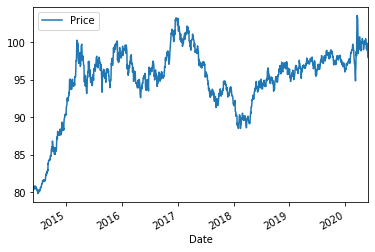

In [11]:
ds.plot()

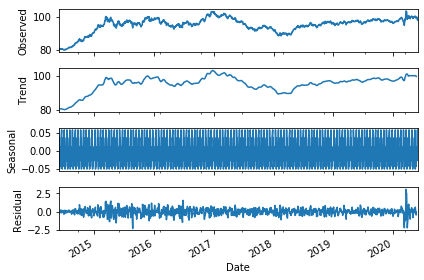

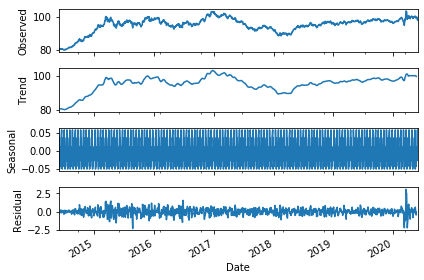

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp=seasonal_decompose(ds['Price'], freq=12)  
decomp.plot()

In [13]:
from statsmodels.tsa.stattools import adfuller
adfuller(ds['Price'])

(-3.1978495158500038,
 0.02010949562282211,
 2,
 1547,
 {'1%': -3.434584120148502,
  '5%': -2.863410105779459,
  '10%': -2.5677656145911203},
 1706.9920768311163)

In [14]:
def adf_chec(time_series):
    result=adfuller(time_series)
    print("Augmented Dickey fuller test")
    labels=['ADF Test Statistic', 'P-value', '#Lags', 'No of obs.']
    for value, label in zip(result, labels):
        print(label + ':' + str(value))
    if result[1]<=0.05:
        print('Strong evidence against null hypothesis, timeseries is stationery')
    else: 
        print('Weak evidence against null hypothesis, timeseries is non-stationery')

In [15]:
adf_chec(ds['Price'])

Augmented Dickey fuller test
ADF Test Statistic:-3.1978495158500038
P-value:0.02010949562282211
#Lags:2
No of obs.:1547
Strong evidence against null hypothesis, timeseries is stationery


In [16]:
ds['Price First Diff']=ds['Price']-ds['Price'].shift(1)  

In [17]:
ds.head()

,Price,Price First Diff
Date,,
2014-05-29,80.540,NaN
2014-05-30,80.404,-0.136
2014-06-02,80.690,0.286
2014-06-03,80.593,-0.097
2014-06-04,80.706,0.113


In [18]:
adf_chec(ds['Price First Diff'].dropna())

Augmented Dickey fuller test
ADF Test Statistic:-12.455077292188411
P-value:3.50555930506094e-23
#Lags:12
No of obs.:1536
Strong evidence against null hypothesis, timeseries is stationery


In [19]:
#p=0;d=1;q=0

In [20]:
ds['Seasonal Difference']=ds['Price']-ds['Price'].shift(12)  

In [21]:
ds.head()

,Price,Price First Diff,Seasonal Difference
Date,,,
2014-05-29,80.540,NaN,NaN
2014-05-30,80.404,-0.136,NaN
2014-06-02,80.690,0.286,NaN
2014-06-03,80.593,-0.097,NaN
2014-06-04,80.706,0.113,NaN


In [22]:
adf_chec(ds['Seasonal Difference'].dropna())

Augmented Dickey fuller test
ADF Test Statistic:-5.526623488984089
P-value:1.826581186134983e-06
#Lags:24
No of obs.:1513
Strong evidence against null hypothesis, timeseries is stationery


In [23]:
#d=1, D=0

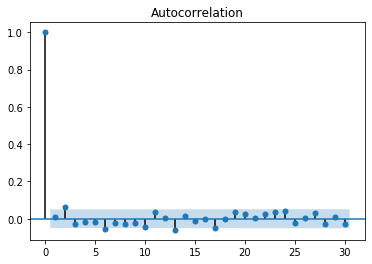

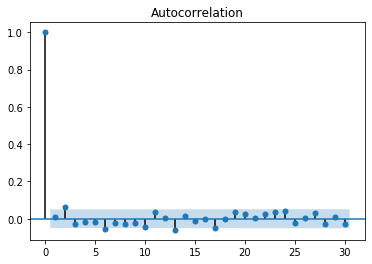

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ds['Price First Diff'].dropna(), lags=30)

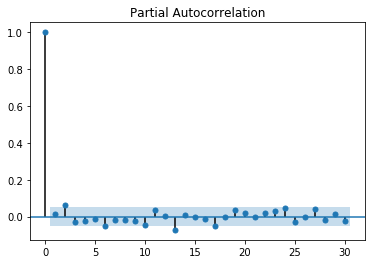

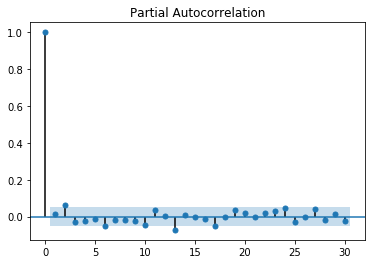

In [25]:
#q=1
plot_pacf(ds['Price First Diff'].dropna(), lags=30)
#p=1

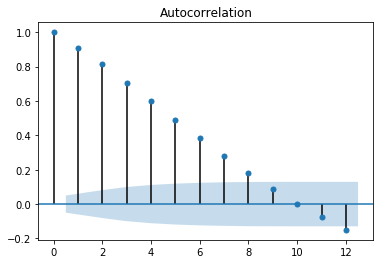

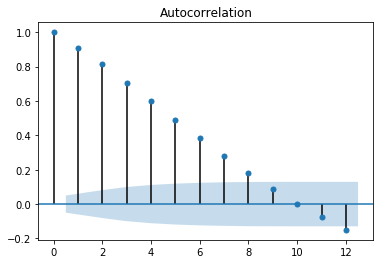

In [26]:
plot_acf(ds['Seasonal Difference'].dropna(), lags=12) #Q=6

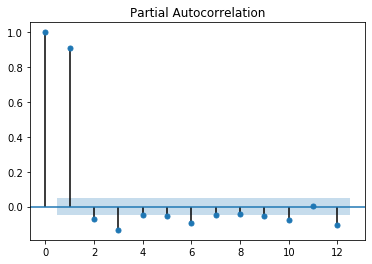

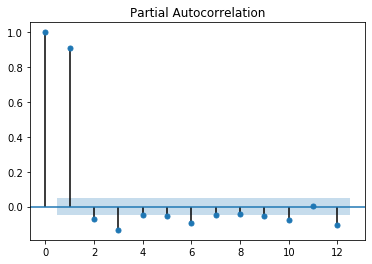

In [27]:
plot_pacf(ds['Seasonal Difference'].dropna(), lags=12) #P=1

In [28]:
#Finally,       AR  I  MA
#      TREND :  1   1  1

#SEASONALITY :  1  0   6


In [29]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(ds['Price'],order=(1,1,1), seasonal_order=(2,1,2,12))
results=model.fit()


C:\Users\Adhvaidh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Adhvaidh\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\Adhvaidh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


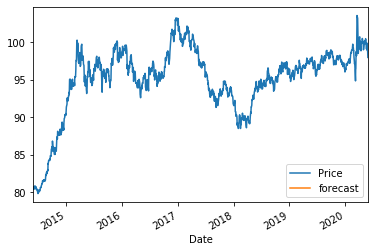

In [30]:
ds['forecast']=results.predict(start=1470, end=1549, dynamic=True)
ds[['Price','forecast']].plot()

In [31]:
from pandas.tseries.offsets import DateOffset
future_dates=[ds.index[-1]+ DateOffset(days=x) for x in range(0,365)]

In [32]:
future_dates_df_1=pd.DataFrame(index=future_dates[1:], columns=ds.columns)
future_df_1=pd.concat([ds,future_dates_df_1])

In [33]:
future_dates_df_1

,Price,Price First Diff,Seasonal Difference,forecast
2020-05-30,NaN,NaN,NaN,NaN
2020-05-31,NaN,NaN,NaN,NaN
2020-06-01,NaN,NaN,NaN,NaN
2020-06-02,NaN,NaN,NaN,NaN
2020-06-03,NaN,NaN,NaN,NaN
2020-06-04,NaN,NaN,NaN,NaN
2020-06-05,NaN,NaN,NaN,NaN
2020-06-06,NaN,NaN,NaN,NaN
2020-06-07,NaN,NaN,NaN,NaN
2020-06-08,NaN,NaN,NaN,NaN


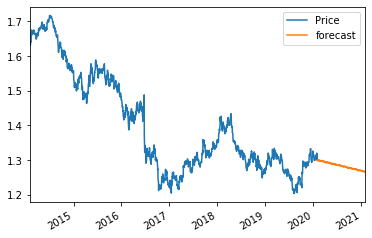

In [69]:
future_df_1['forecast']=results.predict(start=1565, end=1930, dynamic=True)
future_df_1[['Price','forecast']].plot()

In [70]:
future_df_1.tail(-1565)

,Price,Price First Diff,Seasonal Difference,forecast
2020-02-04,1.3031,0.0034,0.0021,1.298796
2020-02-05,NaN,NaN,NaN,1.299240
2020-02-06,NaN,NaN,NaN,1.299844
2020-02-07,NaN,NaN,NaN,1.299304
2020-02-08,NaN,NaN,NaN,NaN
2020-02-09,NaN,NaN,NaN,NaN
2020-02-10,NaN,NaN,NaN,1.300266
2020-02-11,NaN,NaN,NaN,1.299374
2020-02-12,NaN,NaN,NaN,1.298824
2020-02-13,NaN,NaN,NaN,1.298848


In [79]:
future_df_2=future_df_1.drop(['Price','Price First Diff','Seasonal Difference'],axis=1)

In [80]:
future_df_2.tail(-1565)

,forecast
2020-02-04,1.298796
2020-02-05,1.299240
2020-02-06,1.299844
2020-02-07,1.299304
2020-02-08,NaN
2020-02-09,NaN
2020-02-10,1.300266
2020-02-11,1.299374
2020-02-12,1.298824
2020-02-13,1.298848


In [81]:
future_df_2=future_df_2.tail(-1565)

In [82]:
future_df_2.to_excel(r'C:\Users\Adhvaidh\Desktop\USD INR Prediction\GBP INR Prediction.xlsx')